In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
import seaborn as sns

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost

sns.set()

In [3]:
# Load previously saved preprocessed data splits
with open('../results/data_split_nsr.pkl', 'rb') as file:
    data_split_nsr = dill.load(file)

ftr_names = np.array(['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time'])
n_ftrs = len(ftr_names)

In [4]:
results_dict = dict()
res_names = ['linear_regression', 'ridge_regression', 'kn_regression', 'xgb_regression']
regression_dict = {
    'linear_regression': LinearRegression,
    'ridge_regression': Ridge,
    'kn_regression': KNeighborsRegressor,
    'sv_regression': SVR,
    'xgb_regression': xgboost.XGBRegressor
}

for name in res_names:
    with open(f'../results/{name}_results.pkl', 'rb') as file:
        results_dict[name] = dill.load(file)

## Linear Regression Coefficients

In [5]:
model_name = 'linear_regression'
random_idx = 0

coef_list = list()
for split_idx in range(5):
    X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
    X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
    y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

    reg = regression_dict[model_name]()
    params = results_dict[model_name][split_idx][random_idx]['best_params']
    reg.set_params(**params)
    reg.fit(X_train, y_train)
    coef_list.append(reg.coef_)

mean_coef = np.mean(coef_list, axis=0)
error_coef = np.std(coef_list, axis=0)


No handles with labels found to put in legend.


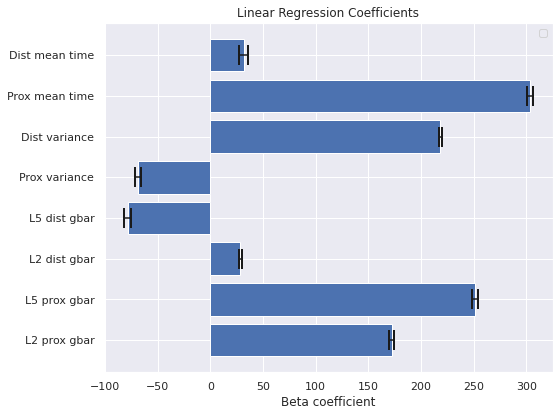

In [6]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.barh(list(range(n_ftrs)), mean_coef)
plt.errorbar(y=list(range(n_ftrs)), x=mean_coef, xerr=error_coef, ecolor='k', capsize=10.0, zorder=12, capthick=2.0, linestyle='')
plt.title("Linear Regression Coefficients")
plt.xlabel('Beta coefficient')
plt.yticks(list(range(n_ftrs)), ftr_names)
plt.legend()
plt.tight_layout()


plt.savefig('../figures/linear_regression_coef.png')

In [7]:
model_name = 'ridge_regression'

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)

coef_list = list()
for split_idx in range(5):
    X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
    X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
    y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

    reg = regression_dict[model_name]()
    params = results_dict[model_name][split_idx][random_idx]['best_params']
    reg.set_params(**params)
    reg.fit(X_train, y_train)
    coef_list.append(reg.coef_)

mean_coef = np.mean(coef_list, axis=0)
error_coef = np.std(coef_list, axis=0)


No handles with labels found to put in legend.


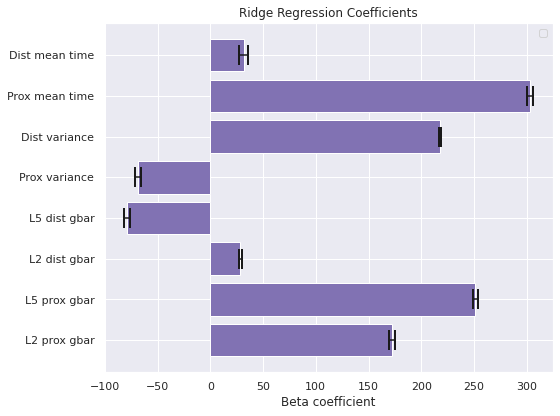

In [8]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.barh(list(range(n_ftrs)), mean_coef, color='C4')
plt.errorbar(y=list(range(n_ftrs)), x=mean_coef, xerr=error_coef, ecolor='k', capsize=10.0, zorder=12, capthick=2.0, linestyle='')
plt.title("Ridge Regression Coefficients")
plt.xlabel('Beta coefficient')
plt.yticks(list(range(n_ftrs)), ftr_names)
plt.legend()
plt.tight_layout()

plt.savefig('../figures/ridge_regression_coef.png')

## Permutation Test

In [9]:
def permutation_importance(X_test, y_test, reg, ftr_names):
    np.random.seed(42)
    test_score = r2_score(y_test, reg.predict(X_test))

    nr_runs = 10
    scores = np.zeros([len(ftr_names),nr_runs])
    print('test score = ',test_score)
    print('test baseline = ',np.sum(y_test == 0)/len(y_test))
    # loop through the features
    for i in range(len(ftr_names)):
        print('shuffling '+str(ftr_names[i]))
        acc_scores = []
        for j in range(nr_runs):
            X_test_shuffled = X_test.copy()
            X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
            y_pred_shuffled = reg.predict(X_test_shuffled)
            acc_scores.append(r2_score(y_pred_shuffled, y_test))
        print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
        scores[i] = acc_scores

    return scores, test_score

In [10]:
model_name = 'kn_regression'
split_idx = 0
random_idx = 0

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)


KNeighborsRegressor(n_jobs=4, n_neighbors=12, weights='distance')

In [11]:
scores, test_score = permutation_importance(X_test, y_test, reg, ftr_names)

test score =  0.6352968288084837
test baseline =  0.0
shuffling L2 prox gbar
   shuffled test score: -0.056 +/- 0.009
shuffling L5 prox gbar
   shuffled test score: -0.111 +/- 0.01
shuffling L2 dist gbar
   shuffled test score: 0.123 +/- 0.006
shuffling L5 dist gbar
   shuffled test score: -0.049 +/- 0.01
shuffling Prox variance
   shuffled test score: -0.304 +/- 0.01
shuffling Dist variance
   shuffled test score: -0.165 +/- 0.01
shuffling Prox mean time
   shuffled test score: -0.567 +/- 0.013
shuffling Dist mean time
   shuffled test score: -0.128 +/- 0.008


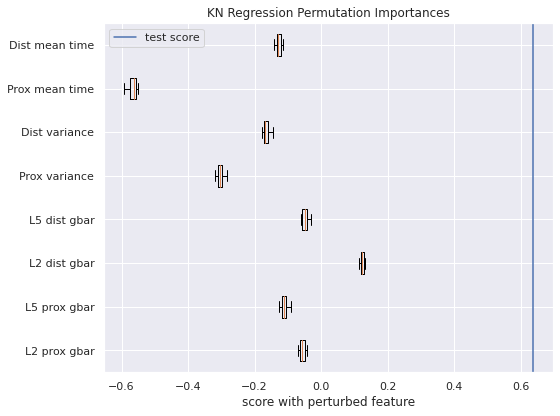

In [12]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores.T,labels=ftr_names,vert=False)
plt.axvline(test_score,label='test score')
plt.title('KN Regression Permutation Importances')
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/kn_regression_permutation.png')

In [13]:
model_name = 'xgb_regression'
split_idx = 0
random_idx = 0

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.66,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
scores, test_score = permutation_importance(X_test, y_test, reg, ftr_names)

test score =  0.6746304765775178
test baseline =  0.0
shuffling L2 prox gbar
   shuffled test score: 0.328 +/- 0.004
shuffling L5 prox gbar
   shuffled test score: -0.05 +/- 0.01
shuffling L2 dist gbar
   shuffled test score: 0.438 +/- 0.002
shuffling L5 dist gbar
   shuffled test score: 0.302 +/- 0.003
shuffling Prox variance
   shuffled test score: -0.526 +/- 0.018
shuffling Dist variance
   shuffled test score: -0.047 +/- 0.01
shuffling Prox mean time
   shuffled test score: -0.625 +/- 0.014
shuffling Dist mean time
   shuffled test score: 0.084 +/- 0.006


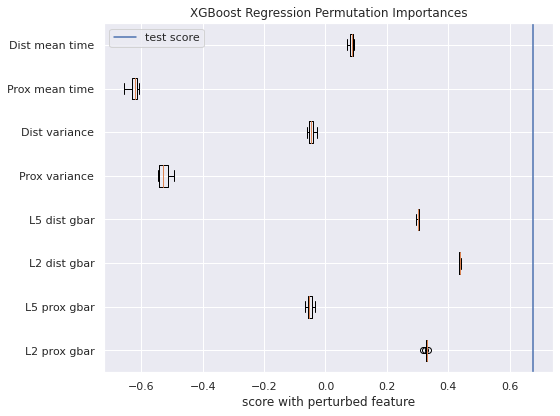

In [15]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores.T,labels=ftr_names,vert=False)
plt.axvline(test_score,label='test score')
plt.title('XGBoost Regression Permutation Importances')
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/xgb_regression_permutation.png')

## XGBoost Feature Importances

In [29]:
model_name = 'xgb_regression'
random_idx = 0

xgb_weights = list()
xgb_gain = list()
for split_idx in range(5):
    X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
    X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
    y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

    reg = regression_dict[model_name]()
    params = results_dict[model_name][split_idx][random_idx]['best_params']
    reg.set_params(**params)
    reg.fit(X_train, y_train)
    xgb_weights.append(reg.get_booster().get_score(importance_type='weight'))
    xgb_gain.append(reg.get_booster().get_score(importance_type='gain'))



In [38]:
xgb_weights_mean = np.mean([list(xgb_weights[idx].values()) for idx in range(5)], axis=0)
xgb_weights_std = np.std([list(xgb_weights[idx].values()) for idx in range(5)], axis=0)

xgb_gain_mean = np.mean([list(xgb_gain[idx].values()) for idx in range(5)], axis=0)
xgb_gain_std = np.std([list(xgb_gain[idx].values()) for idx in range(5)], axis=0)

No handles with labels found to put in legend.


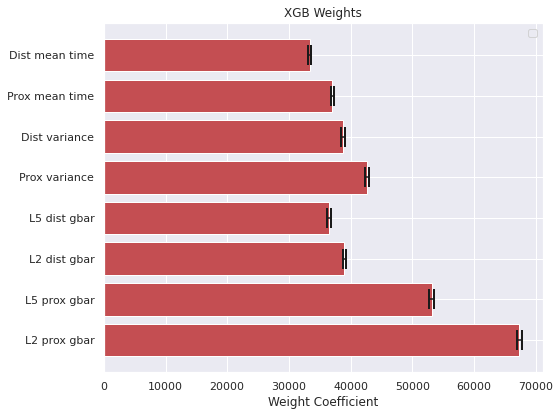

In [43]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.barh(list(range(n_ftrs)), xgb_weights_mean, color='C3')
plt.errorbar(y=list(range(n_ftrs)), x=xgb_weights_mean, xerr=xgb_weights_std, ecolor='k', capsize=10.0, zorder=12, capthick=2.0, linestyle='')
plt.title("XGB Weights")
plt.xlabel('Weight Coefficient')
plt.yticks(list(range(n_ftrs)), ftr_names)
plt.legend()
plt.tight_layout()

plt.savefig('../figures/xgb_weights_coef.png')

No handles with labels found to put in legend.


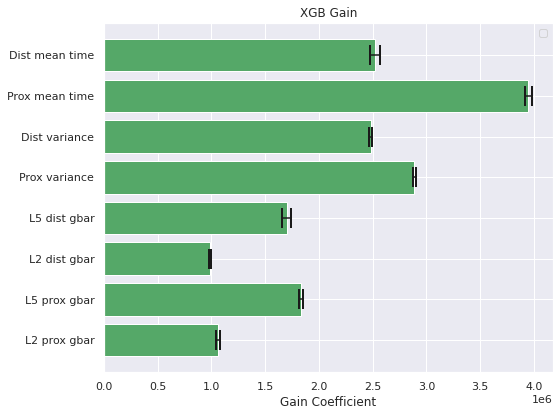

In [47]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.barh(list(range(n_ftrs)), xgb_gain_mean, color='C2')
plt.errorbar(y=list(range(n_ftrs)), x=xgb_gain_mean, xerr=xgb_gain_std, ecolor='k', capsize=10.0, zorder=12, capthick=2.0, linestyle='')
plt.title("XGB Gain")
plt.xlabel('Gain Coefficient')
plt.yticks(list(range(n_ftrs)), ftr_names)
plt.legend()
plt.tight_layout()

plt.savefig('../figures/xgb_gain_coef.png')